In [1]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.10.0


In [3]:
IMAGE_SIZE = 500
num_classes = 3
#batch = 2
LR = 1e-4
EPOCHS = 5

image_path = "./gris/Images/"
mask_path = "./gris/Labels/"
training_data = "Train/"
val_data = "Valid/"
test_data = "Test/"

In [4]:
def load_data():

  TRAIN_X = sorted(glob(os.path.join(image_path + training_data, "*.jpeg")))
  train_x = TRAIN_X[:]
  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.jpeg")))
  train_y = TRAIN_Y[:]

  VALID_X = sorted(glob(os.path.join(image_path + val_data, "*.jpeg")))
  valid_x = VALID_X[:]
  VALID_Y = sorted(glob(os.path.join(mask_path + val_data, "*.jpeg")))
  valid_y = VALID_Y[:]

  TEST_X = sorted(glob(os.path.join(image_path + test_data, "*.jpeg")))
  test_x = TEST_X[:]
  TEST_Y = sorted(glob(os.path.join(mask_path + test_data, "*.jpeg")))
  test_y = TEST_Y[:]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data() 

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.25),
  layers.experimental.preprocessing.RandomContrast(0.1)],
  )

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x
 
 # Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10) #Buffer size needs to be greater or equal to the full size of the dataset
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=4)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [11]:
print(train_x[1].shape)

AttributeError: 'str' object has no attribute 'shape'

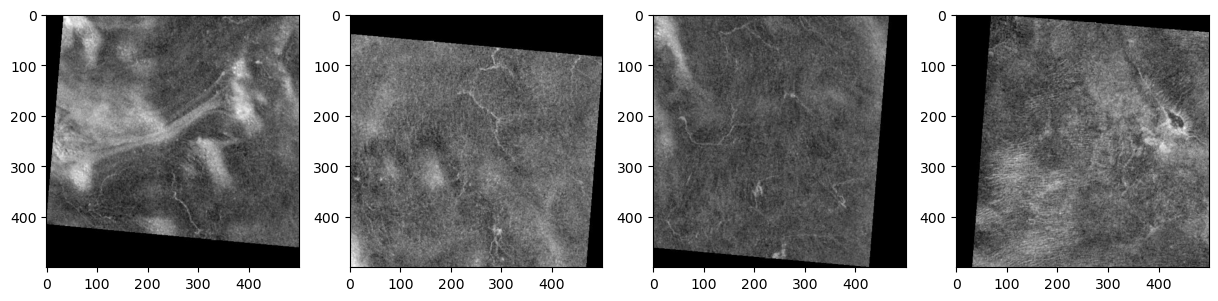

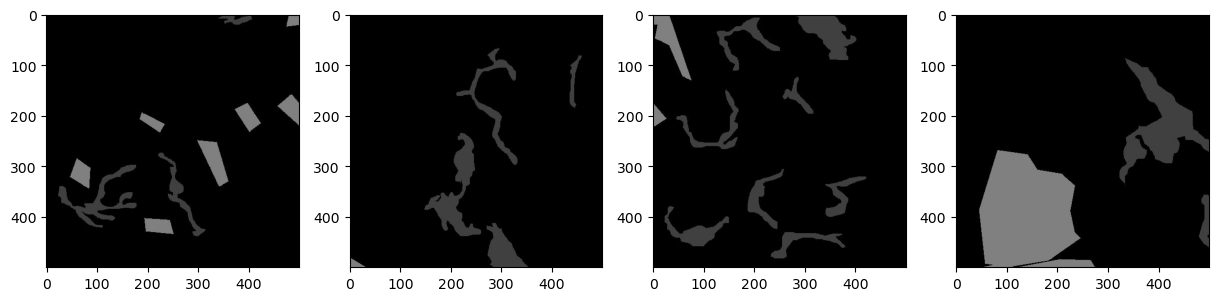

In [7]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)